# 基于 TensorFlow 在 SecretFlow 中实现水平联邦目标检测任务
## 引言
本教程基于 TensorFlow 的 [Object detection with Vision Transformers](https://keras.io/examples/vision/object_detection_using_vision_transformer/) 而改写，通过本教程，您将了解到现有的基于 TensorFlow 的示例如何快速地迁移到 SecretFlow 隐语的联邦学习框架之下，实现模型的联邦学习化。

## 单机模式

### 小节引言
本小节的代码主要来自于 [Object detection with Vision Transformers](https://keras.io/examples/vision/object_detection_using_vision_transformer/) ，主要讲解如何在 Keras 下利用 Vision Transformers 进行目标检测。 在本次示例，教程通过在数据集 [Caltech 101](http://www.vision.caltech.edu/datasets/) 上训练 ViT 在给定图片上检测一架飞机。 为了教程的简洁，本小节仅仅简要介绍了一下各部分的功能；对于实现的具体解析，请读者移步参考[原教程](https://keras.io/examples/vision/object_detection_using_vision_transformer/)。

In [1]:
%load_ext autoreload
%autoreload 2

### 安装依赖包

In [2]:
!python -m pip install -U tensorflow-addons
!python -m pip install -U opencv-python

### 导入第三方库

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

2023-10-13 13:52:41.105986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 13:52:41.232596: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 13:52:41.236588: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-13 13:52:41.236605: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

### 准备数据集

In [4]:
# Path to images and annotations
path_images = "./101_ObjectCategories/airplanes/"
path_annot = "./Annotations/Airplanes_Side_2/"

path_to_downloaded_file = keras.utils.get_file(
    fname="caltech_101_zipped",
    origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
    extract=True,
    archive_format="zip",  # downloaded file format
    cache_dir="/",  # cache and extract in current directory
)

# Extracting tar files found inside main zip file
shutil.unpack_archive("./datasets/caltech-101/101_ObjectCategories.tar.gz", "./")
shutil.unpack_archive("./datasets/caltech-101/Annotations.tar", "./")

# list of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

image_size = 224  # resize input images to this size

images, targets = [], []

# loop over the annotations and images, preprocess them and store in lists
for i in range(0, len(annot_paths)):
    # Access bounding box coordinates
    annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0]

    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    image = keras.utils.load_img(
        path_images + image_paths[i],
    )
    (w, h) = image.size[:2]

    # resize train set images
    if i < int(len(annot_paths) * 0.8):
        # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

137414764/137414764 [==============================] - 587s 4us/step


/tmp/ipykernel_1151154/8725736.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(images[int(len(images) * 0.8) :]),


### 实现多层感知机（MLP）

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### 实现块划分层（the patch creation layer）

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

### 展示输入图像的块划分

2023-10-13 14:02:40.731612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda3/envs/limingbo_sf/lib/python3.8/site-packages/cv2/../../lib64:
2023-10-13 14:02:40.731692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda3/envs/limingbo_sf/lib/python3.8/site-packages/cv2/../../lib64:
2023-10-13 14:02:40.731732: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda3/envs/limingbo_sf/lib/python3.8/site-packages/cv2/../

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


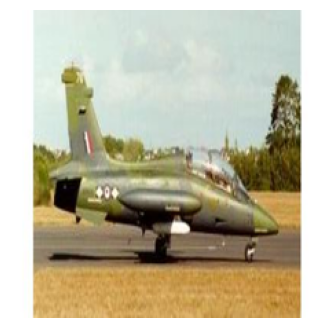

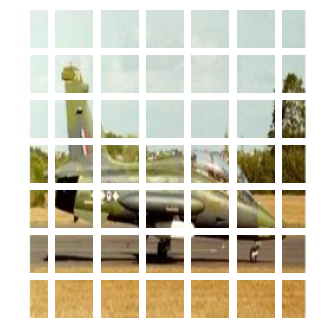

In [7]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### 实现块编码层（the patch encoding layer）

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### 构建 VIT 模型

In [9]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

### 运行实验

In [10]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model.
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history


input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
18/18 [==============================] - 7s 187ms/step - loss: 1.6130 - val_loss: 0.3495
Epoch 2/100
18/18 [==============================] - 3s 142ms/step - loss: 0.3870 - val_loss: 0.3149
Epoch 3/100
18/18 [==============================] - 3s 142ms/step - loss: 0.3286 - val_loss: 0.2803
Epoch 4/100
18/18 [==============================] - 3s 154ms/step - loss: 0.2741 - val_loss: 0.2469
Epoch 5/100
18/18 [==============================] - 3s 145ms/step - loss: 0.2366 - val_loss: 0.2148
Epoch 6/100
18/18 [==============================] - 3s 159ms/step - loss: 0.2001 - val_loss: 0.1853
Epoch 7/100
18/18 [==============================] - 2s 140ms/step - loss: 0.1742 - val_loss: 0.1586
Epoch 8/100
18/18 [==============================] - 2s 141ms/step - loss: 0.1481 - val_loss: 0.1339
Epoch 9/100
18/18 [==============================] - 3s 161ms/step - loss: 0.1266 - val_loss: 0.1115
Epoch 10/100
18/18 [==============================] - 3s 169ms/step - loss: 0.1039 - val_lo

### 可视化训练过程

In [11]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

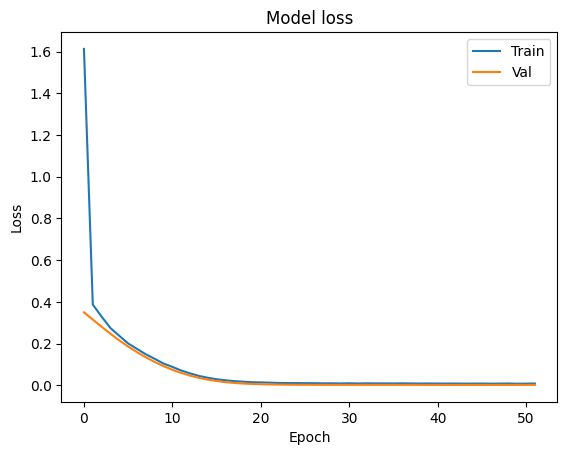

In [12]:
# Plot the change of loss during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### 测试模型

1/1 [==============================] - 0s 80ms/step
mean_iou: 0.8566159723001687


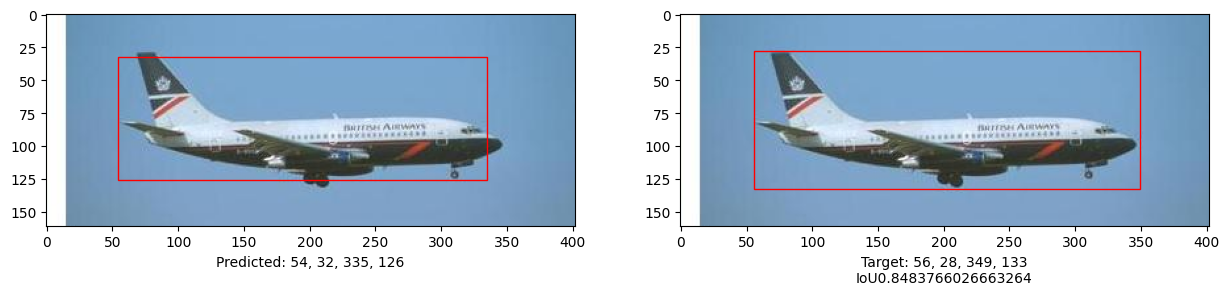

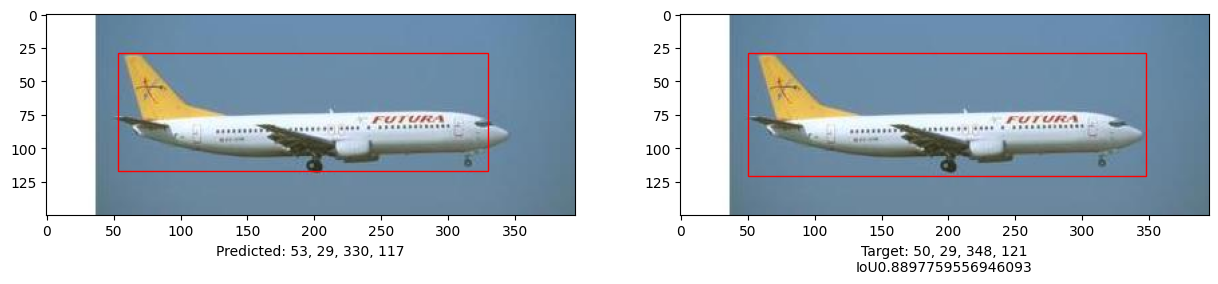

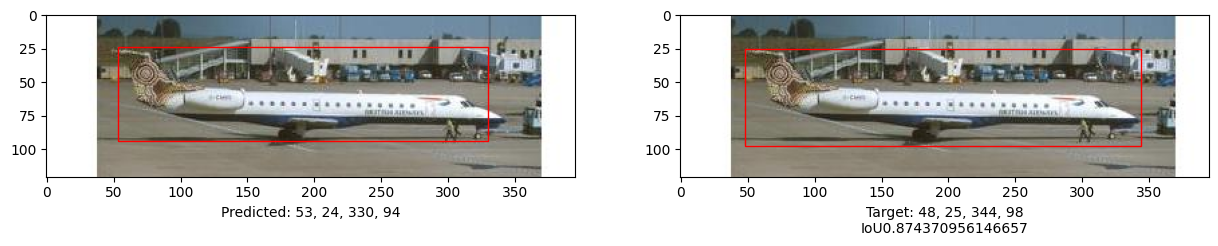

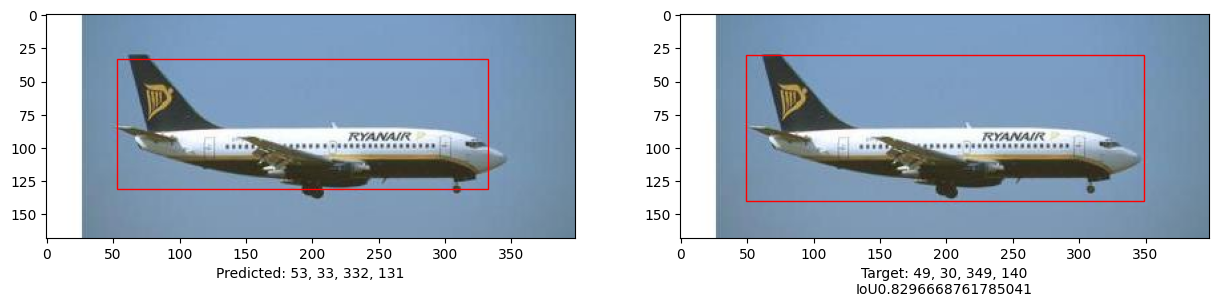

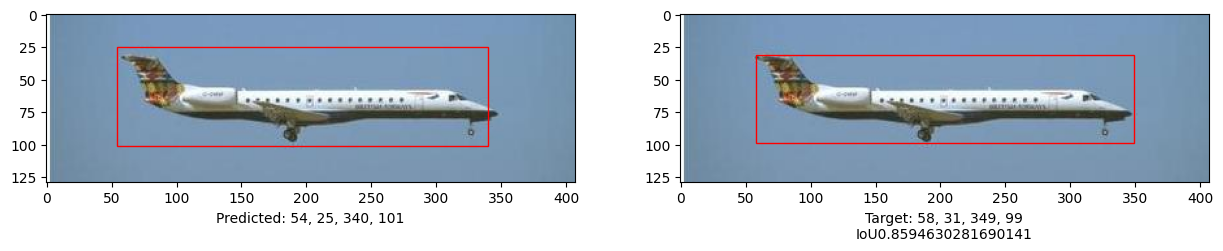

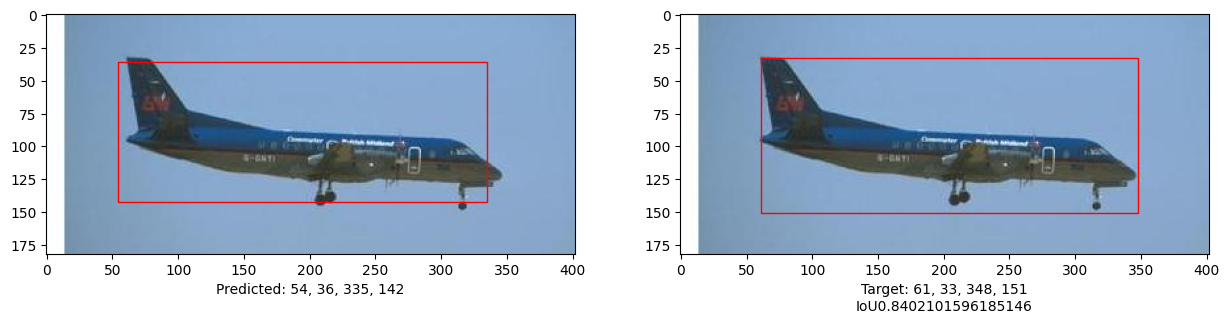

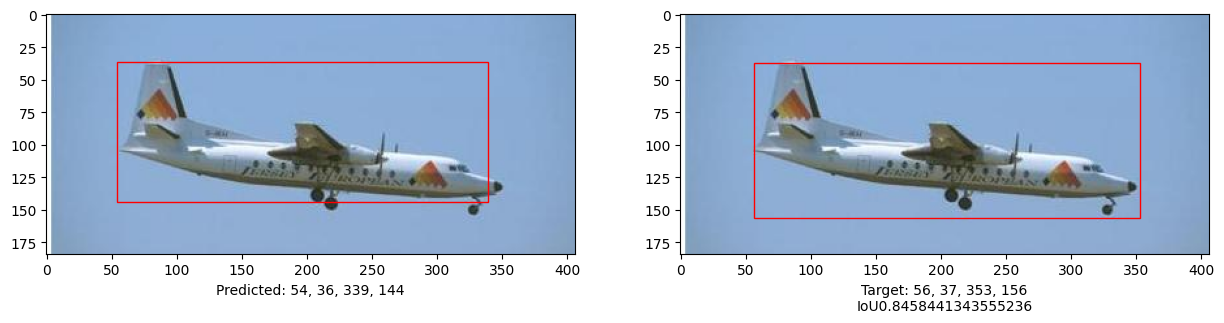

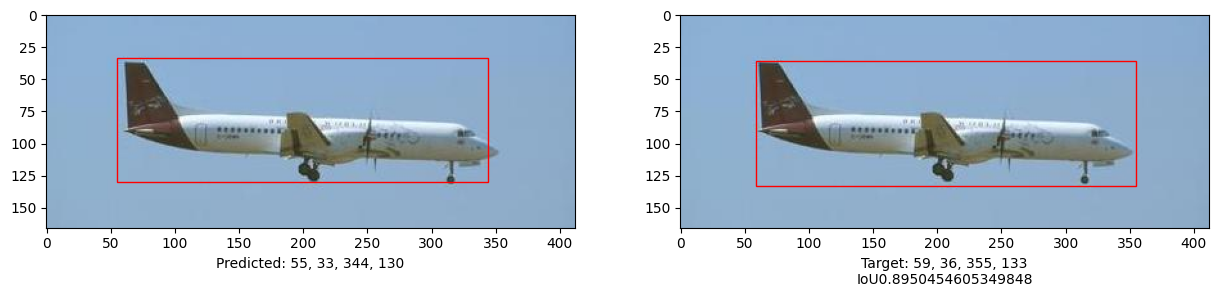

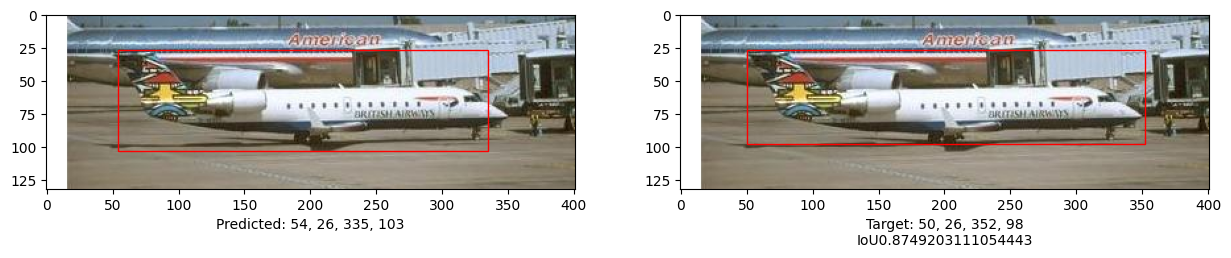

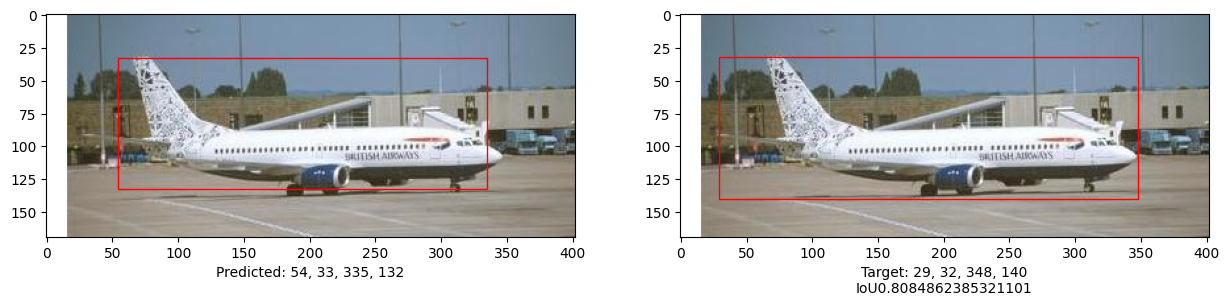

In [13]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")


# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

## 联邦模式

### 小节引言
通过单机模式，我们已经学会到，如何在单机模式下使用  Vision Transformers 实现目标检测，本节我们将看到如何将单机模型如何快速和低成本地迁移到 SecretFlow 隐语的联邦学习框架之下。

### 数据划分
首先为了模拟联邦学习多方参与的场景设定，我们先人为进行一下数据集划分。为方便演示，我们对数据按参与方进行均匀划分

#### 遍历数据集

In [21]:
# Path to images and annotations
path_images = "./101_ObjectCategories/airplanes/"
path_annot = "./Annotations/Airplanes_Side_2/"

# list of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

In [22]:
image_paths

['image_0001.jpg',
 'image_0002.jpg',
 'image_0003.jpg',
 'image_0004.jpg',
 'image_0005.jpg',
 'image_0006.jpg',
 'image_0007.jpg',
 'image_0008.jpg',
 'image_0009.jpg',
 'image_0010.jpg',
 'image_0011.jpg',
 'image_0012.jpg',
 'image_0013.jpg',
 'image_0014.jpg',
 'image_0015.jpg',
 'image_0016.jpg',
 'image_0017.jpg',
 'image_0018.jpg',
 'image_0019.jpg',
 'image_0020.jpg',
 'image_0021.jpg',
 'image_0022.jpg',
 'image_0023.jpg',
 'image_0024.jpg',
 'image_0025.jpg',
 'image_0026.jpg',
 'image_0027.jpg',
 'image_0028.jpg',
 'image_0029.jpg',
 'image_0030.jpg',
 'image_0031.jpg',
 'image_0032.jpg',
 'image_0033.jpg',
 'image_0034.jpg',
 'image_0035.jpg',
 'image_0036.jpg',
 'image_0037.jpg',
 'image_0038.jpg',
 'image_0039.jpg',
 'image_0040.jpg',
 'image_0041.jpg',
 'image_0042.jpg',
 'image_0043.jpg',
 'image_0044.jpg',
 'image_0045.jpg',
 'image_0046.jpg',
 'image_0047.jpg',
 'image_0048.jpg',
 'image_0049.jpg',
 'image_0050.jpg',
 'image_0051.jpg',
 'image_0052.jpg',
 'image_0053

In [23]:
annot_paths

['annotation_0001.mat',
 'annotation_0002.mat',
 'annotation_0003.mat',
 'annotation_0004.mat',
 'annotation_0005.mat',
 'annotation_0006.mat',
 'annotation_0007.mat',
 'annotation_0008.mat',
 'annotation_0009.mat',
 'annotation_0010.mat',
 'annotation_0011.mat',
 'annotation_0012.mat',
 'annotation_0013.mat',
 'annotation_0014.mat',
 'annotation_0015.mat',
 'annotation_0016.mat',
 'annotation_0017.mat',
 'annotation_0018.mat',
 'annotation_0019.mat',
 'annotation_0020.mat',
 'annotation_0021.mat',
 'annotation_0022.mat',
 'annotation_0023.mat',
 'annotation_0024.mat',
 'annotation_0025.mat',
 'annotation_0026.mat',
 'annotation_0027.mat',
 'annotation_0028.mat',
 'annotation_0029.mat',
 'annotation_0030.mat',
 'annotation_0031.mat',
 'annotation_0032.mat',
 'annotation_0033.mat',
 'annotation_0034.mat',
 'annotation_0035.mat',
 'annotation_0036.mat',
 'annotation_0037.mat',
 'annotation_0038.mat',
 'annotation_0039.mat',
 'annotation_0040.mat',
 'annotation_0041.mat',
 'annotation_004

#### 给定参与方
我们假定联邦学习的数据拥有方是 **alice** 和 **bob**

In [24]:
parties_list = ['alice', 'bob']

#### 建立数据文件夹

由上述结果，我们可以看到，目标检测的训练数据集主要由两部分组成：图片（images）和对应的标注（annotation），分别位于 **"./101_ObjectCategories/airplanes/"** 和 **"./Annotations/Airplanes_Side_2/"** ；我们的参与方数据文件夹分别为 **"./fl-data/object_detection/alice/"** 和 **"./fl-data/object_detection/bob/"**；所以我们分别在参与方数据文件夹下建立 **'images'** 和 **'annotation'** 来保存对应的数据。

In [25]:
parties_path_list = []
dataset_name = 'object_detection'
split_dataset_path = os.path.join('.', 'fl-data', dataset_name)
subset_dir = ['images', 'annotation']
for party in parties_list:
    for subset in subset_dir:
        party_path = os.path.join('.', 'fl-data', dataset_name, party, subset)
        os.makedirs(party_path, exist_ok=True)
        parties_path_list.append(party_path)

In [26]:
parties_path_list

['./fl-data/object_detection/alice/images',
 './fl-data/object_detection/alice/annotation',
 './fl-data/object_detection/bob/images',
 './fl-data/object_detection/bob/annotation']

#### 定义数据划分函数

In [27]:
from os.path import join
import shutil


def split_dataset(data_dir_path, file_path_list, parties_list, dataset_name, subset):
    parties_num = len(parties_list)
    index = 0
    for item_name in file_path_list:
        item_path = join(data_dir_path, item_name)
        target_dir_path = join(
            '.', 'fl-data', dataset_name, parties_list[index % parties_num], subset
        )
        shutil.copy(item_path, target_dir_path)
        print(f'copy {item_path} -->{target_dir_path}')
        index += 1

#### 进行图像数据集划分

In [28]:
split_dataset(path_images, image_paths, parties_list, dataset_name, subset='images')

copy ./101_ObjectCategories/airplanes/image_0001.jpg -->./fl-data/object_detection/alice/images
copy ./101_ObjectCategories/airplanes/image_0002.jpg -->./fl-data/object_detection/bob/images
copy ./101_ObjectCategories/airplanes/image_0003.jpg -->./fl-data/object_detection/alice/images
copy ./101_ObjectCategories/airplanes/image_0004.jpg -->./fl-data/object_detection/bob/images
copy ./101_ObjectCategories/airplanes/image_0005.jpg -->./fl-data/object_detection/alice/images
copy ./101_ObjectCategories/airplanes/image_0006.jpg -->./fl-data/object_detection/bob/images
copy ./101_ObjectCategories/airplanes/image_0007.jpg -->./fl-data/object_detection/alice/images
copy ./101_ObjectCategories/airplanes/image_0008.jpg -->./fl-data/object_detection/bob/images
copy ./101_ObjectCategories/airplanes/image_0009.jpg -->./fl-data/object_detection/alice/images
copy ./101_ObjectCategories/airplanes/image_0010.jpg -->./fl-data/object_detection/bob/images
copy ./101_ObjectCategories/airplanes/image_0011.j

#### 进行标注数据集划分

In [29]:
split_dataset(path_annot, annot_paths, parties_list, dataset_name, subset='annotation')

copy ./Annotations/Airplanes_Side_2/annotation_0001.mat -->./fl-data/object_detection/alice/annotation
copy ./Annotations/Airplanes_Side_2/annotation_0002.mat -->./fl-data/object_detection/bob/annotation
copy ./Annotations/Airplanes_Side_2/annotation_0003.mat -->./fl-data/object_detection/alice/annotation
copy ./Annotations/Airplanes_Side_2/annotation_0004.mat -->./fl-data/object_detection/bob/annotation
copy ./Annotations/Airplanes_Side_2/annotation_0005.mat -->./fl-data/object_detection/alice/annotation
copy ./Annotations/Airplanes_Side_2/annotation_0006.mat -->./fl-data/object_detection/bob/annotation
copy ./Annotations/Airplanes_Side_2/annotation_0007.mat -->./fl-data/object_detection/alice/annotation
copy ./Annotations/Airplanes_Side_2/annotation_0008.mat -->./fl-data/object_detection/bob/annotation
copy ./Annotations/Airplanes_Side_2/annotation_0009.mat -->./fl-data/object_detection/alice/annotation
copy ./Annotations/Airplanes_Side_2/annotation_0010.mat -->./fl-data/object_detec

### 封装 DataBuilder
在迁移过程，对于数据集的预处理方式，联邦学习模式和单机模式是一样的，我们不再重复。为了完成迁移适配过程，我们只需要参考[在 SecretFlow 中使用自定义 DataBuilder（TensorFlow）](https://github.com/secretflow/secretflow/blob/main/docs/tutorial/CustomDataLoaderTF.ipynb) 封装我们自定义 DataBuilder 即可。现在，参考原教程，我们封装对应的DataBuilder，所以我们也不需要额外写很多代码。

In [30]:
def create_dataset_builder(
    batch_size=32,
):
    def dataset_builder(folder_path, stage="train"):
        import math

        import tensorflow as tf

        # get the path of dataset
        path_images = os.path.join(folder_path, 'images/')
        path_annot = os.path.join(folder_path, 'annotation/')
        # path_images = "./101_ObjectCategories/airplanes/"
        # path_annot = "./Annotations/Airplanes_Side_2/"

        # list of paths to images and annotations
        image_paths = [
            f
            for f in os.listdir(path_images)
            if os.path.isfile(os.path.join(path_images, f))
        ]
        annot_paths = [
            f
            for f in os.listdir(path_annot)
            if os.path.isfile(os.path.join(path_annot, f))
        ]

        image_paths.sort()
        annot_paths.sort()

        image_size = 224  # resize input images to this size

        images, targets = [], []

        # loop over the annotations and images, preprocess them and store in lists
        for i in range(0, len(annot_paths)):
            # Access bounding box coordinates
            annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0]

            top_left_x, top_left_y = annot[2], annot[0]
            bottom_right_x, bottom_right_y = annot[3], annot[1]

            image = keras.utils.load_img(
                path_images + image_paths[i],
            )
            (w, h) = image.size[:2]

            # resize train set images
            # if i < int(len(annot_paths) * 0.8):
            # resize image if it is for training dataset
            image = image.resize((image_size, image_size))

            # convert image to array and append to list
            images.append(keras.utils.img_to_array(image))

            # apply relative scaling to bounding boxes as per given image and append to list
            targets.append(
                (
                    float(top_left_x) / w,
                    float(top_left_y) / h,
                    float(bottom_right_x) / w,
                    float(bottom_right_y) / h,
                )
            )

        # Convert the list to numpy array, split to train and test dataset
        (x_train), (y_train) = (
            np.asarray(images[: int(len(images) * 0.8)]),
            np.asarray(targets[: int(len(targets) * 0.8)]),
        )
        (x_test), (y_test) = (
            np.asarray(images[int(len(images) * 0.8) :]),
            np.asarray(targets[int(len(targets) * 0.8) :]),
        )

        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        eval_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

        SHUFFLE_BUFFER_SIZE = 1024
        train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
        eval_dataset = eval_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)

        if stage == "train":
            train_step_per_epoch = math.ceil(x_train.shape[0] / batch_size)
            return train_dataset, train_step_per_epoch
        elif stage == "eval":
            eval_step_per_epoch = math.ceil(x_test.shape[0] / batch_size)
            return eval_dataset, eval_step_per_epoch

    return dataset_builder

### 隐语环境初始化

In [31]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()
sf.init(['alice', 'bob', 'charlie'], address="local", log_to_driver=False)
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.2.0.dev20231009


2023-10-13 14:08:30,428	INFO worker.py:1538 -- Started a local Ray instance.


### 构建 dataset_builder_dict

In [32]:
data_builder_dict = {
    alice: create_dataset_builder(
        batch_size=32,
    ),
    bob: create_dataset_builder(
        batch_size=32,
    ),
}

### 定义网络结构
得益于隐语优异的设计，我们只需要将单机模式下定义的网络结构，进行适当的封装即可。具体到本教程，可以看到我们直接参考单机模式下 **run_experiment**的实现，封装对应的模型即可，同时我们可以继续复用单机模式下定义的 **create_vit_object_detector** 函数，只需要给定对应的参数即可。

In [33]:
def create_fl_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    def create_model():
        model = create_vit_object_detector(
            input_shape,
            patch_size,
            num_patches,
            projection_dim,
            num_heads,
            transformer_units,
            transformer_layers,
            mlp_head_units,
        )

        optimizer = tfa.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        )

        # Compile model.
        model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

        return model

    return create_model

### 定义 TensorFlow 后端的 FLModel 

In [34]:
from secretflow.ml.nn import FLModel
from secretflow.security.aggregation import SecureAggregator

In [35]:
device_list = [alice, bob]
aggregator = SecureAggregator(charlie, [alice, bob])

# prepare model
image_size = 224
input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

# keras model
model = create_fl_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)


fed_model = FLModel(
    device_list=device_list,
    model=model,
    aggregator=aggregator,
    backend="tensorflow",
    strategy="fed_avg_w",
    random_seed=1234,
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


### 给出参与方数据集路径

In [ ]:
data = {
    alice: './fl-data/object_detection/alice',
    bob: './fl-data/object_detection/bob',
}

### 训练联邦学习模型

In [36]:

checkpoint_filepath = "logs/"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

history = fed_model.fit(
    data,
    None,
    validation_data=data,
    epochs=num_epochs,
    batch_size=batch_size,
    aggregate_freq=2,
    sampler_method="batch",
    random_seed=1234,
    dp_spent_step_freq=1,
    dataset_builder=data_builder_dict,
    callbacks=[
        checkpoint_callback,
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
    ],
)

INFO:root:FL Train Params: {'x': {PYURuntime(alice): './fl-data/object_detection/alice', PYURuntime(bob): './fl-data/object_detection/bob'}, 'y': None, 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 100, 'verbose': 1, 'callbacks': [<keras.callbacks.ModelCheckpoint object at 0x7fbc9507ad60>, <keras.callbacks.EarlyStopping object at 0x7fbc9507abe0>], 'validation_data': {PYURuntime(alice): './fl-data/object_detection/alice', PYURuntime(bob): './fl-data/object_detection/bob'}, 'shuffle': False, 'class_weight': None, 'sample_weight': None, 'validation_freq': 1, 'aggregate_freq': 2, 'label_decoder': None, 'max_batch_size': 20000, 'prefetch_buffer_size': None, 'sampler_method': 'batch', 'random_seed': 1234, 'dp_spent_step_freq': 1, 'audit_log_dir': None, 'dataset_builder': {PYURuntime(alice): <function create_dataset_builder.<locals>.dataset_builder at 0x7fbb983078b0>, PYURuntime(bob): <function create_dataset_builder.<locals>.dataset_builder at 0x7fbb9831b310>}, 'wait_steps': 100, 

### 可视化训练历史

In [37]:
history.global_history.keys()

dict_keys(['loss', 'val_loss'])

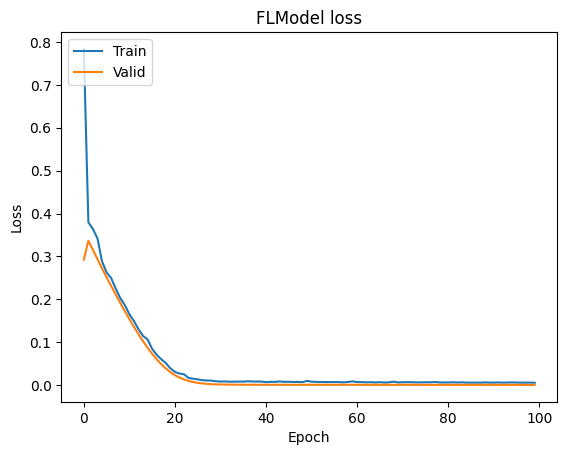

In [38]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history.global_history['loss'])
plt.plot(history.global_history['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

至此，我们很好地完成了联邦学习模型的训练

## 小结

通过本教程，您将看到，如何将 Keras 的目标检测模型快速迁移到 SecretFlow 隐语 的联邦学习框架之下，实现目标检测模型的联邦学习